#  1 Preparation 准备

## 1.1 数据展示

每个npy文件前3个元素是原始图像的RGB三个通道，第4个元素是背景遮罩，第5-12个元素是车辆模块的遮罩，第13个元素是车辆所有模块的混合遮罩

图片来自imagenet, 所以图片的mean = [0.485,0.456,0.406], std = [0.229,0.224,0.225]

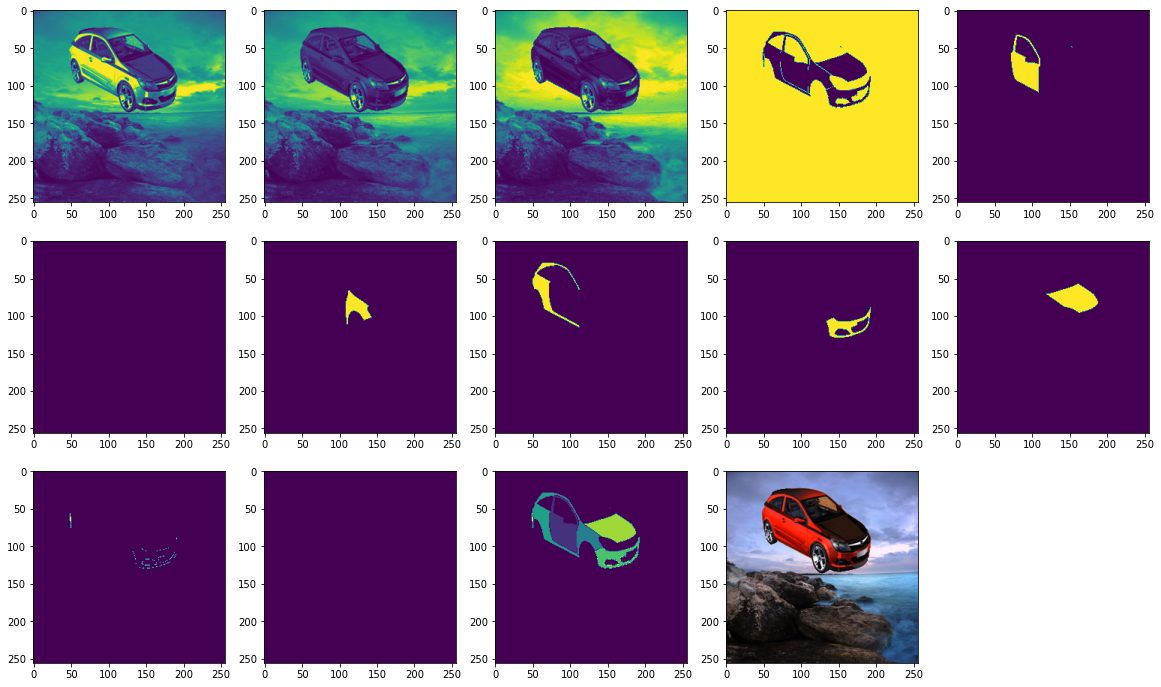

In [20]:
import numpy as np
import matplotlib.pyplot as plt
pic = np.load("./clean_data/OPEL_1991.npy")
plt.figure(figsize=(20,12))
for i in range(pic.shape[0]):
    plt.subplot(3,5,i+1)
    plt.imshow(pic[i])
plt.subplot(3,5,14)
raw_img = np.empty((256,256,3))
raw_img[:,:,0] = pic[0,:,:] + 0.485 / 0.229
raw_img[:,:,1] = pic[1,:,:] + 0.456 / 0.224
raw_img[:,:,2] = pic[2,:,:] + 0.406 / 0.225
plt.imshow(raw_img)

type(raw_img[6,7,0])
import cv2
img_float32 = np.float32(raw_img) # cv2 only support 32bit float
img_cv = cv2.cvtColor(img_float32, cv2.COLOR_RGB2BGR)
cv2.imshow('car', img_cv)

## 1.2 Image resize and Normalization

In [9]:
from PIL import Image
def image_size_alignment(path,size=(256,256)):
    img = Image.open(path)
    temp = max(img.size)
    mask = Image.new('RGB', (temp,temp),(0,0,0))
    mask.paste(img,(0,0))
    mask.resize(size)
    return mask

## 1.3 Data generator 数据生成器
- 'background': (,,),
- 'front_door': (20, 100, 20),
- 'back_door': (250, 250, 10),
- 'fender': (20, 20, 250),
- 'frame': (10, 250, 250),
- 'bumper': (250, 10, 250),
- 'hood': (250, 150, 10),
- 'back_bumper': (150, 10, 150),
- 'trunk': (10, 250, 10)

In [10]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

class CarDataset(Dataset):
    def __init__(self,path):
        self.path = path
        self.names = os.listdir(path)
        for i, name in enumerate(self.names):
            if os.path.splitext(name)[1] != '.npy':
                # three way to delete, pop(index), del list[index], remove(value). and clear() wipe out all
                self.names.pop(i)

    def __len__(self):
        return len(self.names)

    def __getitem__(self, index):
        name = self.names[index]
        path = os.path.join(self.path, name)
        img = np.load(path).astype(np.double)
        car_img = img[:3] # normalized 3 channel
        segment_img = img[-1]
        # mask_img = img[x].reshape((1,256,256)) (from 4-12)
        mask_img = img[3:11]
        return car_img, mask_img

### 1.3.1 Unit test 单元测试

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


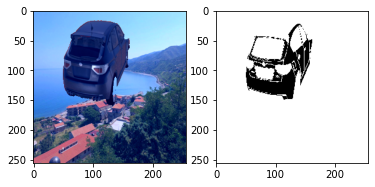

In [11]:
# unit test
# if __name__ == '__main__':
data = CarDataset('./clean_data')
idx = random.randint(0,len(data))
car_img = data[idx][0].transpose(1,2,0)+2.0
car_mask = data[idx][1]
plt.subplot(1,2,1)
plt.imshow(car_img)
plt.subplot(1,2,2)
plt.imshow(car_mask[0], cmap=plt.cm.gray)

# 2 Network 网络模型

<!--![U-net](U-net.png =150x)-->
<img src="./U-net.png" width="600"  alt="network"/><br/>

1. padding reflect symmetry mirror 不能只用0填充，利用镜像填充的方法使整张图都是有特征的，加强特征处理的能力
2. maxpooling lost too much feature, convolution instead  最大池化丢特征太严重换成卷积 

## 2.1 Sub unit
1. conv 3x3
2. down sampling: maxpool 2x2
3. up sampling: up-conv 2x2
4. concat

In [12]:
import torch
from torch import nn
from torch.nn import functional as F

class ConvBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(ConvBlock,self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channel, out_channel,3,1,1,padding_mode='reflect',bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channel, out_channel,3,1,1,padding_mode='reflect',bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True)
        )
    def forward(self,x):
        return self.layer(x)

class DownSampling(nn.Module):
    def __init__(self, channel):
        super(DownSampling,self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(channel,channel,3,2,1,padding_mode='reflect',bias=False),
            nn.BatchNorm2d(channel),
            nn.ReLU()
        )
    def forward(self,x):
        return self.layer(x)

class UpSampling(nn.Module):
    def __init__(self, channel):
        super(UpSampling,self).__init__()
        self.layer = nn.Conv2d(channel,channel//2,1,1)
    def forward(self,x,feature_map):
        up = F.interpolate(x,scale_factor=2,mode='nearest')
        out = self.layer(up)
        return torch.cat((out,feature_map),dim=1)

## 2.2 U-net

In [13]:
class UNet(nn.Module):
    def __init__(self ) -> None:
        super().__init__()
        # [conv -> down sampling] for 4 times
        self.c1 = ConvBlock(3,64)
        self.d1 = DownSampling(64)
        self.c2 = ConvBlock(64,128)
        self.d2 = DownSampling(128)
        self.c3 = ConvBlock(128,256)
        self.d3 = DownSampling(256)
        self.c4 = ConvBlock(256,512)
        self.d4 = DownSampling(512)
        self.c5 = ConvBlock(512,1024)
        # [up sampling -> concat] for 4 times
        self.u1 = UpSampling(1024)  # 512u1+512c4
        self.c6 = ConvBlock(1024,512)
        self.u2 = UpSampling(512)   # 256u2+256c4
        self.c7 = ConvBlock(512,256)
        self.u3 = UpSampling(256)   # 128u2+128c4
        self.c8 = ConvBlock(256,128)
        self.u4 = UpSampling(128)   # 64u2 + 64c4
        self.c9 = ConvBlock(128,64)
        # final conv
        self.out = nn.Conv2d(64,1,3,1,1) # 3 channel
        self.th  = nn.Sigmoid()

    def forward(self,x):
        L1 = self.c1(x)
        L2 = self.c2(self.d1(L1))
        L3 = self.c3(self.d2(L2))
        L4 = self.c4(self.d3(L3))
        L5 = self.c5(self.d4(L4))
        R1 = self.c6(self.u1(L5,L4))
        R2 = self.c7(self.u2(R1,L3))
        R3 = self.c8(self.u3(R2,L2))
        R4 = self.c9(self.u4(R3,L1))
        R5 = self.th(self.out(R4))
        return R5

### 2.2.1 Unit test 单元测试

In [14]:
## if __name__ == '__main__':
x = torch.randn(2,3,256,256)
net = UNet()
net(x).shape

torch.Size([2, 1, 256, 256])

### 2.2.2

In [ ]:
from torchvision import models
net = UNet()
net

In [ ]:
import torch
from torchvision import models
from torchsummary import summary
net = UNet()
summary(net, (3,256,256))

# 3 Training 训练

In [52]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.utils import save_image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weight_path = r'./params/unet.pth'
data_path = r'./clean_data'
save_path = r'./train_image.png'

data_loader = DataLoader(CarDataset(data_path), batch_size=2,shuffle=True)
net = UNet().to(device)
if os.path.exists(weight_path):
    net.load_state_dict(torch.load(weight_path))
    print('successful load weights ( 加载网络权重成功 ) !')
else:
    print('not successful load weights ( 加载网络权重失败 ) !')

opt = optim.Adam(net.parameters())
loss_fun = nn.BCELoss()

epoch = 1
while True:
    for i, (img, mask) in enumerate(data_loader):
        # img, mask = img.to(device), mask.to(device)
        # print(f"标记点1:类型为{type(img[0,0,0,0])},数据维度为{img.shape}")
        img, mask = img.to(torch.float32), mask.to(torch.float32)
        out = net(img)
        train_loss = loss_fun(out, mask)

        opt.zero_grad()
        train_loss.backward()
        opt.step()

        if (i+1)&5 == 0:
            print(f'{epoch}-{i+1}: train_loss =====>> {train_loss.item()}')
        
        if (i+1)%50 == 0:
            torch.save(net.state_dict(),weight_path)
        
        _img = img[0]
        _mask = torch.cat([mask[0],mask[0],mask[0]], dim=0)
        _out = torch.cat([out[0],out[0],out[0]], dim=0)

        _concat_img = torch.stack([_img+2.2, _mask, _out],dim=0)

        save_image(_concat_img, save_path)
    epoch += 1


not successful load weights ( 加载网络权重失败 ) !
1-2: train_loss =====>> 0.7080780863761902
1-8: train_loss =====>> 0.41780802607536316
1-10: train_loss =====>> 0.23685956001281738
1-16: train_loss =====>> 0.15316349267959595
1-18: train_loss =====>> 0.09242282807826996
1-24: train_loss =====>> 0.2690836191177368
1-26: train_loss =====>> 0.17274077236652374
1-32: train_loss =====>> 0.04270350933074951
1-34: train_loss =====>> 0.086784727871418
1-40: train_loss =====>> 0.05623197555541992
1-42: train_loss =====>> 0.13804444670677185
1-48: train_loss =====>> 0.019553808495402336
1-50: train_loss =====>> 0.1593780368566513


FileNotFoundError: [Errno 2] No such file or directory: './params/unet.pth'